In [91]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
import scipy.stats as stats

In [110]:
prior_file = '../pbjam/data/prior_data.csv'

prior = pd.read_csv(prior_file)
prior = prior.drop(columns=['ID', 'eps_g', 'p_L0', 'p_D0', 'alpha_g', 'u1', 'u2', 'DPi1'])
prior = prior.dropna()
''' If you want to reduce the volume of the prior - here is the place to do it!'''
prior = prior[prior.numax > np.log10(800.0)]
print(len(prior))
prior.head()

129


,numax,dnu,teff,bp_rp,eps_p,d02,alpha_p,env_height,env_width,mode_width,H1_nu,H1_exp,H_power,H2_nu,H2_exp,d01
13545,3.162672,1.881135,3.826075,0.575040,0.844761,0.767839,-2.695059,0.401082,2.307066,0.174625,3.218119,3.652768,3.137152,2.681778,3.308408,1.530153
13546,3.172406,1.881879,3.780245,0.766897,1.278135,0.710442,-2.548862,0.402757,2.292339,0.148777,3.152802,2.922546,3.204265,2.597299,3.325006,1.541007
13547,3.063642,1.787840,3.799065,0.660747,1.148833,0.711050,-2.908139,0.581869,2.207637,0.066642,3.082645,3.171502,3.103027,2.554328,3.048859,1.441060
13548,3.203482,1.897359,3.799616,0.663745,1.104225,0.808687,-2.929498,0.270082,2.296077,0.113081,3.201763,2.840464,3.138864,2.659919,3.352889,1.570424
13549,3.146686,1.862615,3.806655,0.715504,0.993497,0.709866,-3.053164,0.143703,2.211589,0.086142,3.113774,3.009173,3.158740,2.534407,3.465917,1.528664


In [105]:
class params():
    def __init__(self, prior: pd.core.frame.DataFrame, pca_components=5):
        self.prior_cloud = prior
        self.ndim = pca_components
        self.obs = {}
        
    def set_obs(self, name: str, vals: np.array):
        ''' Set an observable in the observable dictionary
        
        name: str
            name of the observable that matches an observable in the prior
            
        vals: arraylike
            [mean, uncertainty]
        '''
        self.obs[name] = vals
        
    def run_pca(self):
        ''' Run PCA on the prior to get a continuous latent representation '''
        X = self.prior_cloud.values
        from sklearn.decomposition import PCA
        self.pca = PCA(n_components=self.ndim)
        latent = self.pca.fit_transform(X)
        print(f'PCA Explained variance total = {np.sum(self.pca.explained_variance_ratio_)}')
        self.latent_mean = np.mean(latent, axis=0)
        self.latent_std = np.std(latent, axis=0)
        
    def prior_transform(self, u):
        ''' Transform from unit cube to latent space '''
        x = np.copy(u)
        for i in range(self.ndim):
            x[i] = stats.norm.ppf(x[i], loc=self.latent_mean[i], scale=self.latent_std[i])
        return x
    
    def log_likelihood(self, latent):
        p = self.pca.inverse_transform(latent)
        ll = 0.0
        for name, val in self.obs.items():
            idx = list(self.prior_cloud.columns.values).index(name)
            ll += stats.norm.logpdf(p[idx], loc=val[0], scale=val[1])
        return ll
    
    def sample(self):
        import dynesty
        sampler = dynesty.NestedSampler(self.log_likelihood, self.prior_transform, self.ndim,
                                bound='single', nlive=200)
        sampler.run_nested()
        samples_equal = sampler.results.samples_equal()
        return  self.pca.inverse_transform(samples_equal)
        
    def __call__(self):
        print(self.prior_cloud.head())


In [107]:
p = params(prior)
p()
p.set_obs('dnu', [np.log10(135.0), 0.01])
p.set_obs('numax', [np.log10(3050.0), 0.01])
p.set_obs('teff', [np.log10(5777.), 0.015])
p.run_pca()

u = np.random.rand(5)
latent = p.prior_transform(u)
p.log_likelihood(latent)
samples = p.sample()

         numax       dnu      teff     bp_rp     eps_p       d02   alpha_p  \
711   2.993137  1.748721  3.743902  0.936217  1.437755  0.601810 -3.268724   
1163  3.056376  1.790688  3.763128  0.862216  1.382435  0.778154 -3.297644   
1604  2.932298  1.684309  3.736556  0.970967  1.397454  0.716601 -2.758143   
1713  2.925378  1.692291  3.772542  0.843357  1.432931  0.707959 -2.534071   
2171  3.103480  1.833976  3.789440  0.738458  1.413263  0.728377 -2.887189   

      env_height  env_width  mode_width     H1_nu    H1_exp   H_power  \
711     0.584318   1.960230   -0.187943  2.970684  3.237452  3.772420   
1163    0.656435   1.980680   -0.134599  2.994326  3.032668  3.492433   
1604    1.042723   2.005202   -0.106269  2.854863  4.272459  3.671218   
1713    0.681062   1.997663   -0.149565  2.874650  3.711477  3.680680   
2171    0.541177   2.225190    0.019924  3.054797  3.057458  3.614931   

         H2_nu    H2_exp  
711   2.425723  3.020671  
1163  2.416618  2.389446  
1604  2.329

1438it [00:34, 42.26it/s, +200 | bound: 102 | nc: 1 | ncall: 37390 | eff(%):  4.404 | loglstar:   -inf < 10.615 <    inf | logz:  5.094 +/-  0.150 | dlogz:  0.001 >  0.209]


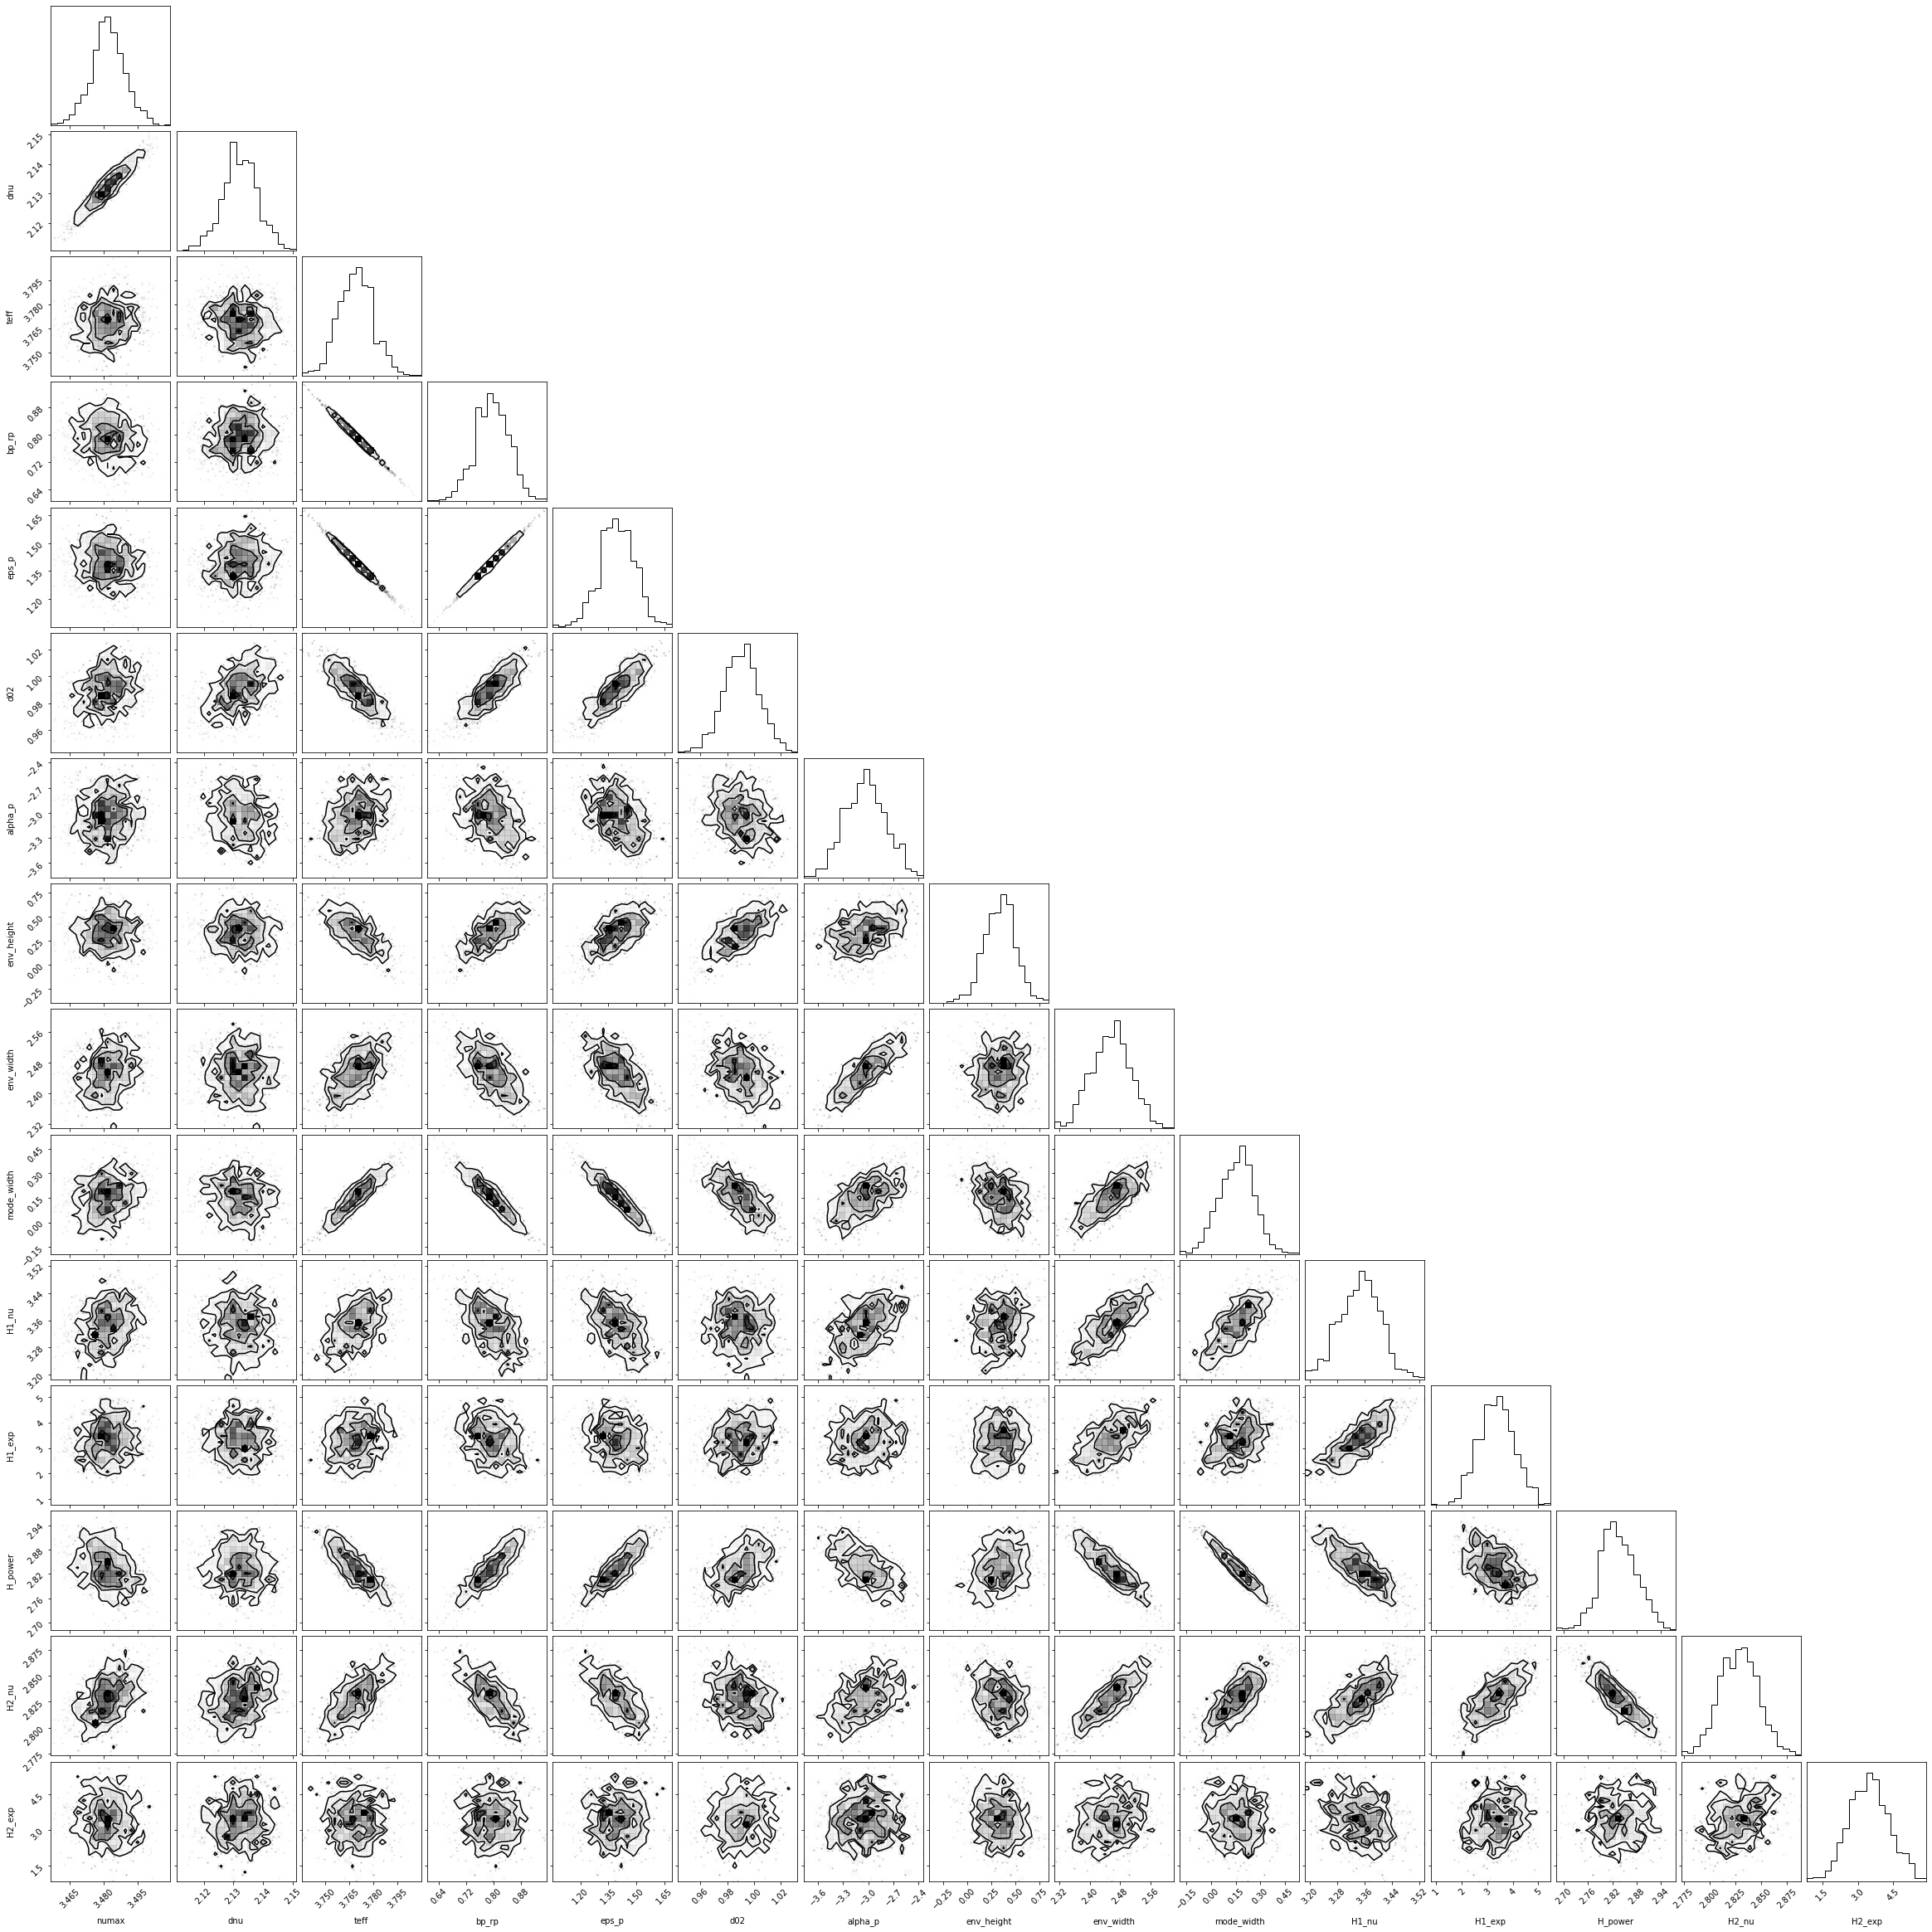

In [111]:
corner.corner(samples, labels=p.prior_cloud.columns);